# Edge and node perturbations equivalences

## Modules

In [44]:
import ginsim
import biolqm
import numpy as np
print('numpy: '+np.version.full_version)
import matplotlib
print('matplotlib: '+matplotlib.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd # for the visualization of lists of states
import scipy.stats
import networkx as nx

numpy: 1.17.2
matplotlib: 3.1.1


## Functions

### Partitioning of unitary perturbations

In [45]:
def unit_perturbation_partitioning(nodes_p,edges_p,mod):
    ##Computes sets of networks obtained by unitary pertubations of 1) nodes 2) edges
    node_net={(pert,biolqm.perturbation(mod, pert)) for pert in nodes_p}
    edge_net={(pert,biolqm.perturbation(mod, pert)) for pert in edges_p}
    ##A node and an edge perturbation are equivalent if they lead to the same network
    node_edge_eq={(node,edge,net1) for (node,net1) in node_net for (edge,net2) in edge_net if biolqm.to_minibn(net1)==biolqm.to_minibn(net2)}   
    ##set of  node perturbation having at least an equivalent edge perturbation
    nodes_eq={node for (node,edge,net) in node_edge_eq}
    ##set of  edge perturbation equivalent to an edge perturbation
    edges_eq={edge for (node,edge,net) in node_edge_eq}
    ##list of  (node,{edge_set}) equivalent perturbations
    node_edge=list((node2,{edge for (node1,edge,net) in node_edge_eq if node1==node2}) for node2 in nodes_eq)
    ##list of  node-only perturbations
    node_only=set(nodes_p-nodes_eq)
    ##list of  edge-only perturbations
    edge_only=set(edges_p-edges_eq)
    return dict({'node-eq':nodes_eq,'edge-eq' : edges_eq,'node-only' : node_only,'edge-only':edge_only})

In [104]:
def partition_from_model(model, conceptual_nodes):

    ## Loading model + Booleanization with Biolqm
    lqm= biolqm.load(model)
    ## Simplification with minibn
    bn = biolqm.to_minibn(biolqm.booleanize(lqm)).simplify()
    ## Booleanized model 
    mod = bn.to_biolqm()
    ## Influence graph 
    ig = biolqm.influence_graph(mod)

    ##Generation of unitary nodes perturbations
    nodes=set([str(c) for c in mod.getComponents()])
    internal_nodes=nodes-conceptual_nodes
    nodes_p={str(c)+'%0' for c in internal_nodes}.union({str(c)+'%1' for c in internal_nodes})

    ##Generation of unitary edges perturbations
    internal_edges=[(source,target) for (source,target) in ig.edges() if target in internal_nodes and source in internal_nodes]
    edges_p={str(source) +':'+str(target)+'%0' for (source,target) in internal_edges}.union({str(source) +':'+str(target)+'%1' for (source,target) in internal_edges})
    partition_dict=unit_perturbation_partitioning(nodes_p,edges_p,mod)

    return partition_dict

### Vizualisation

In [49]:
def partition_pert_count(partition_dict):
    node_eq=len(partition_dict['node-eq'])
    edge_eq=len(partition_dict['edge-eq'])
    node_only=len(partition_dict['node-only'])
    edge_only=len(partition_dict['edge-only'])
    return [node_eq,edge_eq,node_only,edge_only]

In [134]:
def dict_to_histogram(partition_dict,model_name):
    res= partition_pert_count(partition_dict)
    x = ["node","edge"]
    y1 = np.array([res[0],res[1]])
    y2 = np.array([res[2],res[3]])
    
    yrange=res[1]+res[3]

# memo of sample number
    snum = y1+y2

# normalization
#y1 = y1/snum*100.
#y2 = y2/snum*100.

    plt.figure(figsize=(12,9))

# stack bars
    plt.bar(x, y1, label='equiv')
    plt.bar(x, y2 ,bottom=y1,label='not equiv')

# add text annotation corresponding to the percentage of each data.
    for xpos, ypos, yval in zip(x, y1/2, y1):
        plt.text(xpos, ypos, "%d"%yval, ha="center", va="center")
    for xpos, ypos, yval in zip(x, y1+y2/2, y2):
        plt.text(xpos, ypos, "%d"%yval, ha="center", va="center")
# add text annotation corresponding to the "total" value of each bar
    for xpos, ypos, yval in zip(x, y1+y2, snum):
        plt.text(xpos, ypos, "N=%d"%yval, ha="center", va="bottom")

    plt.ylim(0,yrange+10)

    plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left')
    ##sav figure
    plt.savefig(model_name, bbox_inches='tight', pad_inches=0.02)
    return res

## Application to cancer signalling models

Downloading http://ginsim.org/sites/default/files/Bladder_Model.zginml

[28, 60, 26, 124]

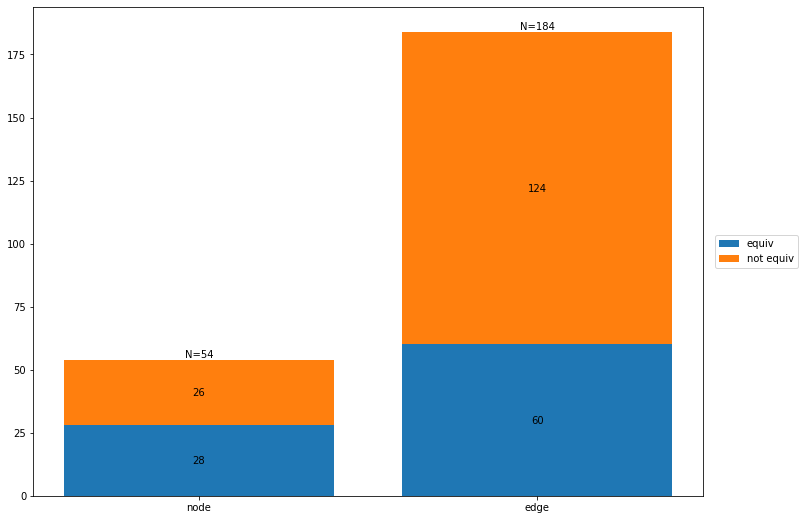

In [135]:
##Bladder model
model="http://ginsim.org/sites/default/files/Bladder_Model.zginml"
conceptual_nodes={'Proliferation','Growth_Arrest','Apoptosis_b1',
 'Apoptosis_b2','DNAdamage', 'GrowthInhibitors','EGFR_stimulus','FGFR3_stimulus'}

partition_dict=partition_from_model(model,conceptual_nodes)

dict_to_histogram(partition_dict,"Bladder")

Downloading http://ginsim.org/sites/default/files/Flobak_FullModel_S2_Dataset.zginml

[108, 165, 46, 145]

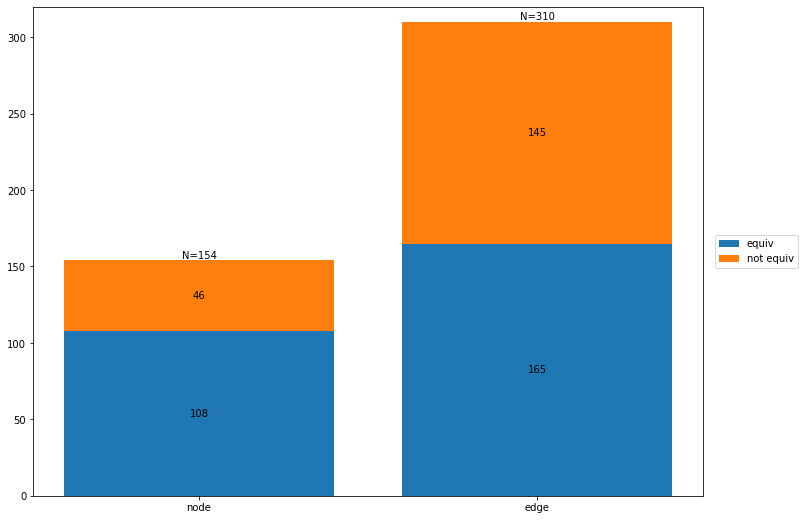

In [136]:
##Gastric model
model="http://ginsim.org/sites/default/files/Flobak_FullModel_S2_Dataset.zginml"
conceptual_nodes={'Prosurvival_b1',
 'Prosurvival_b2',
 'Prosurvival_b3','Antisurvival_b1',
 'Antisurvival_b2',
 'Antisurvival_b3',}

partition_dict=partition_from_model(model,conceptual_nodes)

dict_to_histogram(partition_dict,"Gastric")

In [ ]:
##TLGL model
model="http://ginsim.org/sites/default/files/T_LGL.zginml"
conceptual_nodes={'Stimuli','Stimuli2','Apoptosis','Proliferation','Cyt_sign'}

partition_dict=partition_from_model(model,conceptual_nodes)

dict_to_histogram(partition_dict,"TLGL")

In [ ]:
##CRC model
model="http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml"
conceptual_nodes={'CellCycleArrest','DNAdamage','Apoptosis','Proliferation','ECMicroenv', 'Invasion',
 'Metastasis','Migration'}

partition_dict=partition_from_model(model,conceptual_nodes)

dict_to_histogram(partition_dict,"CRC")


## Brouillon

In [46]:
## Loading the model with Ginsim
lrg1 = ginsim.load("http://ginsim.org/sites/default/files/Flobak_FullModel_S2_Dataset.zginml")
## Converting the model to biolqm + Booleanization
lqm1= biolqm.load("http://ginsim.org/sites/default/files/Flobak_FullModel_S2_Dataset.zginml")
bn = biolqm.to_minibn(biolqm.booleanize(lqm1)).simplify()

## Booleanized model 
mod1 = bn.to_biolqm()

## Influence graph 
ig = biolqm.influence_graph(mod1)

## Conceptual nodes/readouts 
outputs ={'Prosurvival_b1',
 'Prosurvival_b2',
 'Prosurvival_b3','Antisurvival_b1',
 'Antisurvival_b2',
 'Antisurvival_b3',}

##Generation of unitary nodes perturbations
nodes=set([str(c) for c in mod1.getComponents()])
internal_nodes=nodes-outputs
nodes_p={str(c)+'%0' for c in internal_nodes}.union({str(c)+'%1' for c in internal_nodes})

##Generation of unitary edges perturbations
internal_edges=[(source,target) for (source,target) in ig.edges() if target in internal_nodes and source in internal_nodes]
edges_p={str(source) +':'+str(target)+'%0' for (source,target) in internal_edges}.union({str(source) +':'+str(target)+'%1' for (source,target) in internal_edges})
partition_dict=unit_perturbation_partitioning(nodes_p,edges_p,mod1)

Downloading http://ginsim.org/sites/default/files/Flobak_FullModel_S2_Dataset.zginml

Downloading http://ginsim.org/sites/default/files/Flobak_FullModel_S2_Dataset.zginml

In [58]:
len(internal_nodes)

77

In [59]:
len(internal_edges)

155

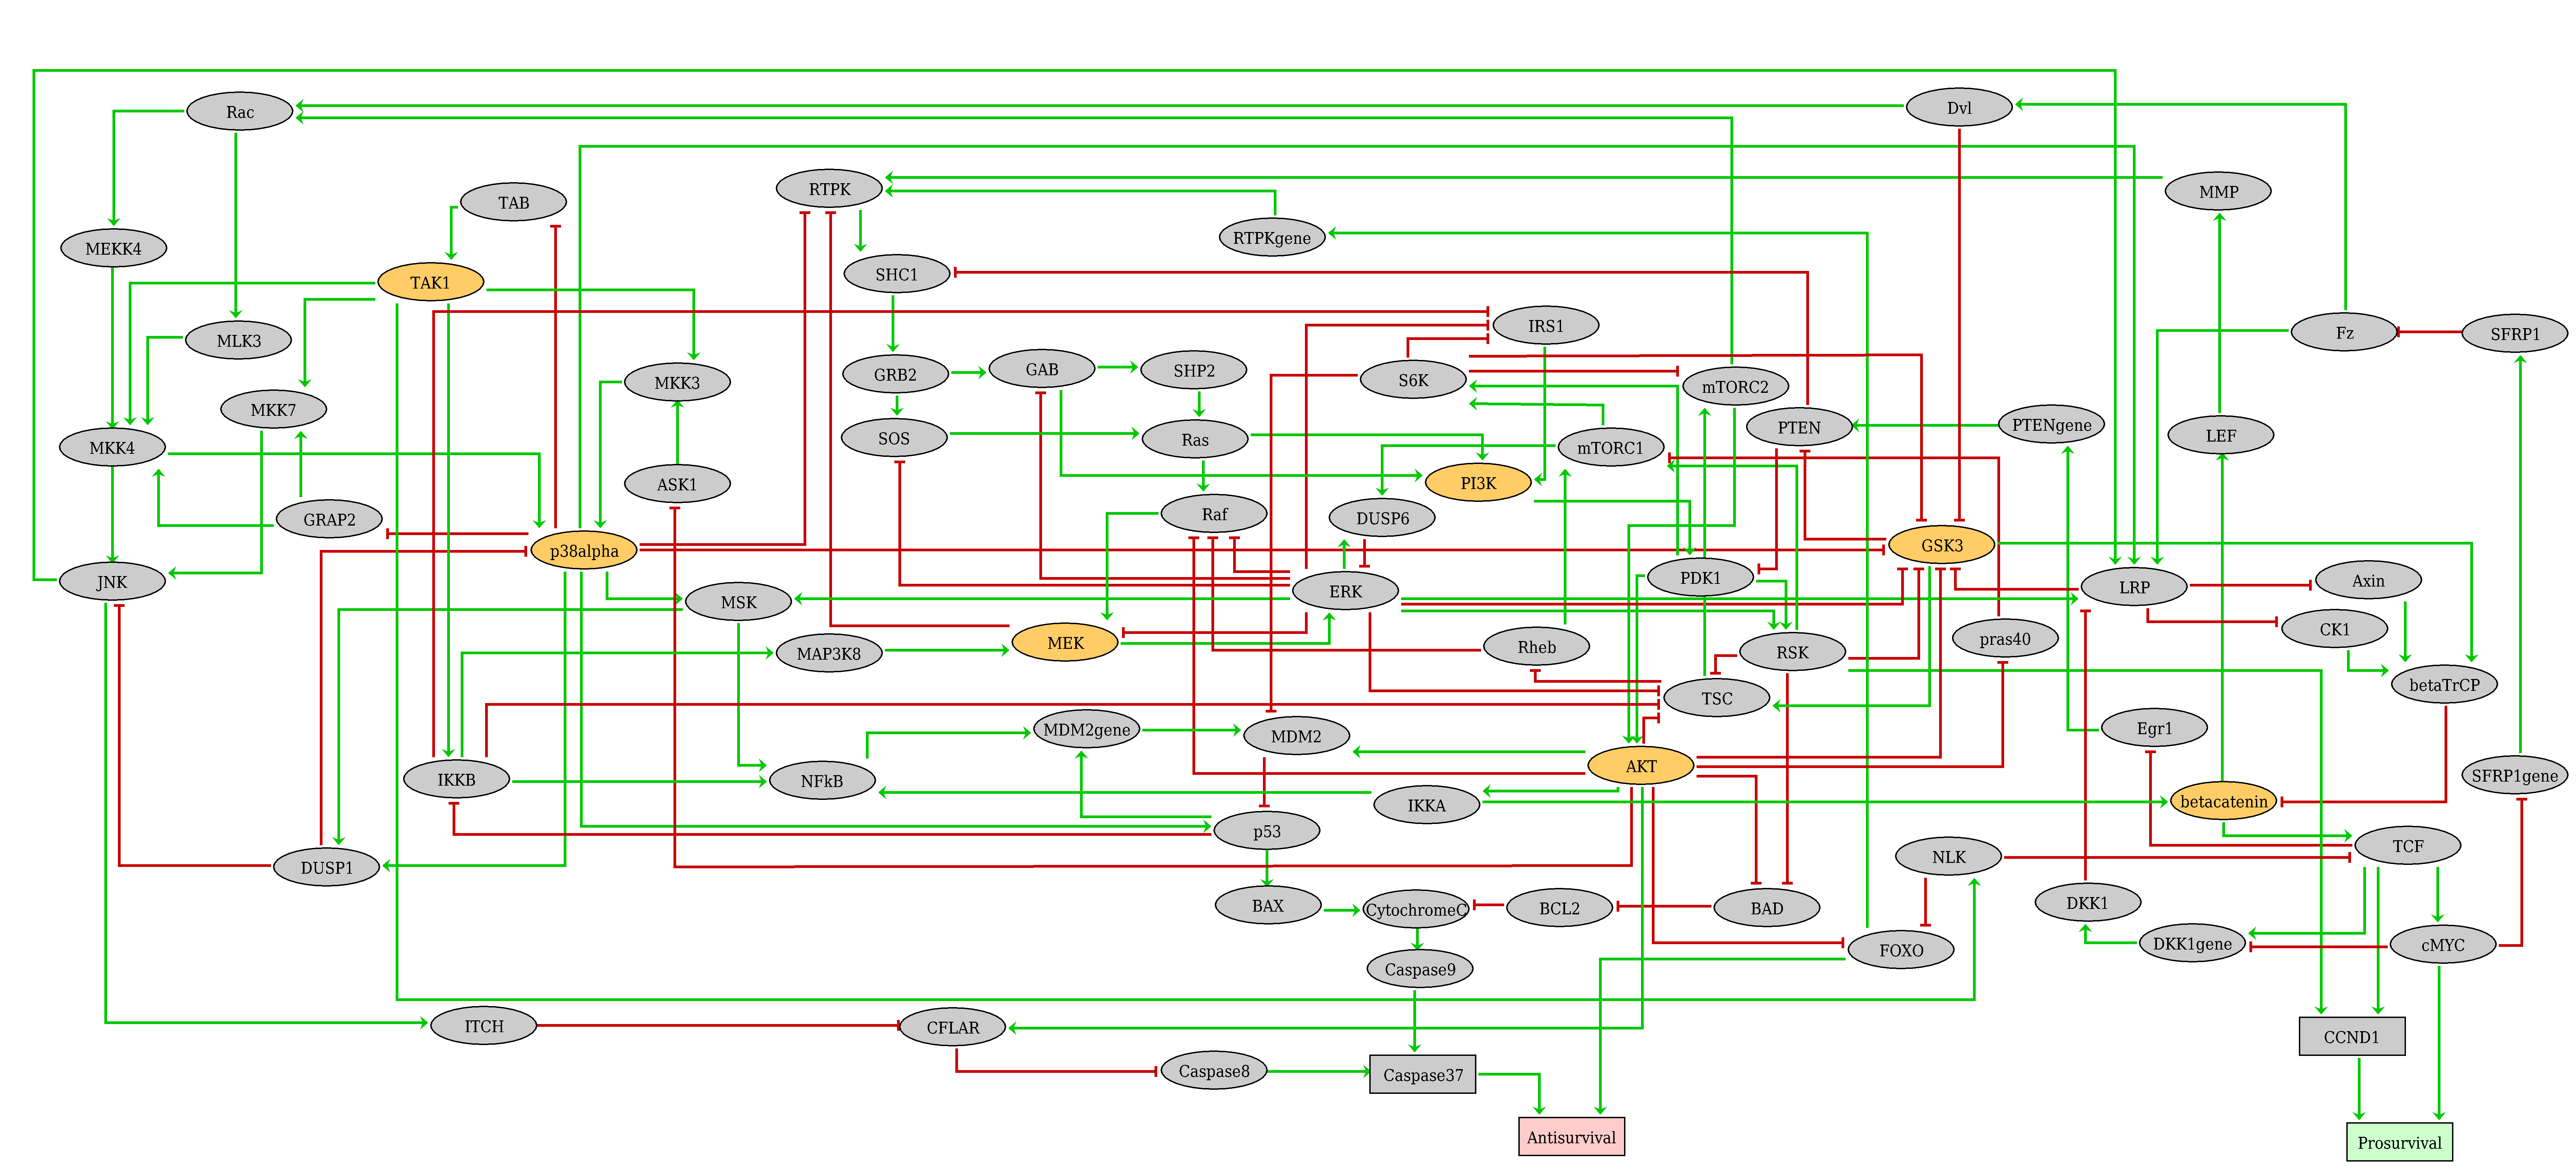

In [60]:
ginsim.show(lrg1)

In [52]:
res2=partition_pert_count(partition_dict)

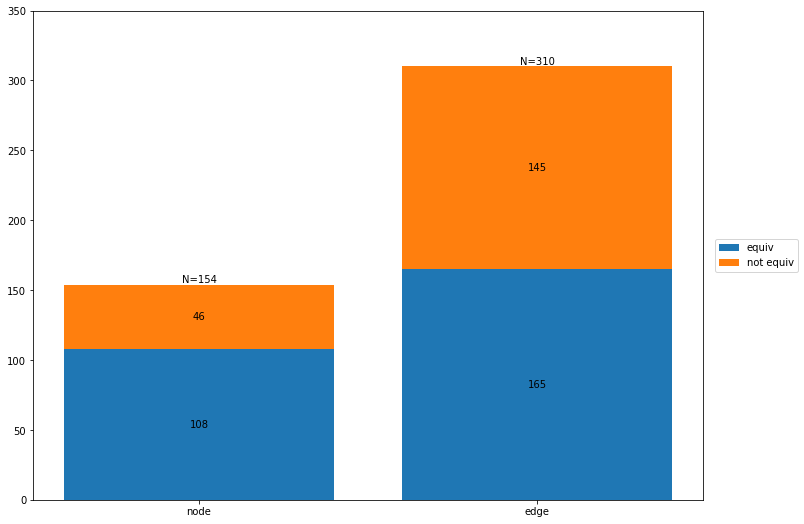

In [55]:
x = ["node","edge"]
y1 = np.array([res2[0],res2[1]])
y2 = np.array([res2[2],res2[3]])

# memo of sample number
snum = y1+y2

# normalization
#y1 = y1/snum*100.
#y2 = y2/snum*100.

plt.figure(figsize=(12,9))

# stack bars
plt.bar(x, y1, label='equiv')
plt.bar(x, y2 ,bottom=y1,label='not equiv')

# add text annotation corresponding to the percentage of each data.
for xpos, ypos, yval in zip(x, y1/2, y1):
    plt.text(xpos, ypos, "%d"%yval, ha="center", va="center")
for xpos, ypos, yval in zip(x, y1+y2/2, y2):
    plt.text(xpos, ypos, "%d"%yval, ha="center", va="center")
# add text annotation corresponding to the "total" value of each bar
for xpos, ypos, yval in zip(x, y1+y2, snum):
    plt.text(xpos, ypos, "N=%d"%yval, ha="center", va="bottom")

plt.ylim(0,350)

plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left')
plt.savefig('normalized_stacked_barplot_with_number.png', bbox_inches='tight', pad_inches=0.02)

In [127]:
yrange=max(154,310)
yrange

310

In [35]:
nodes=list(nx.nodes(ig))
ig.in_degree(nodes)

InMultiDegreeView({'PDK1': 2, 'AKT': 2, 'mTORC2': 2, 'ASK1': 1, 'Antisurvival_b1': 4, 'Antisurvival_b2': 6, 'Caspase37_b1': 4, 'FOXO': 2, 'Antisurvival_b3': 5, 'Caspase37_b2': 3, 'LRP': 5, 'Axin': 1, 'BAD': 2, 'RSK': 2, 'p53': 2, 'BAX': 1, 'BCL2': 1, 'CCND1_b1': 4, 'CCND1_b2': 3, 'TCF': 2, 'CFLAR': 2, 'ITCH': 1, 'CK1': 1, 'Caspase8': 1, 'Caspase9': 1, 'CytochromeC': 2, 'DKK1gene': 2, 'DKK1': 1, 'cMYC': 1, 'MSK': 2, 'DUSP1': 2, 'p38alpha': 3, 'ERK': 2, 'DUSP6': 2, 'mTORC1': 3, 'Fz': 1, 'Dvl': 1, 'MEK': 3, 'Egr1': 1, 'NLK': 1, 'SFRP1': 1, 'GAB': 2, 'GRB2': 1, 'GRAP2': 1, 'SHC1': 2, 'GSK3': 7, 'S6K': 2, 'IKKA': 1, 'TAK1': 1, 'IKKB': 2, 'IRS1': 3, 'JNK': 3, 'MKK4': 4, 'MKK7': 2, 'betacatenin': 2, 'LEF': 1, 'MAP3K8': 1, 'MDM2': 3, 'MDM2gene': 2, 'NFkB': 3, 'Raf': 4, 'Rac': 2, 'MEKK4': 1, 'MKK3': 2, 'MLK3': 1, 'MMP': 1, 'PI3K': 3, 'PTEN': 2, 'Ras': 2, 'PTENgene': 1, 'Prosurvival_b1': 4, 'Prosurvival_b2': 6, 'Prosurvival_b3': 5, 'RTPK': 4, 'RTPKgene': 1, 'Rheb': 1, 'SHP2': 1, 'SOS': 2, 'TSC':

In [36]:
ig.out_degree(nodes)

OutMultiDegreeView({'PDK1': 3, 'AKT': 10, 'mTORC2': 2, 'ASK1': 1, 'Antisurvival_b1': 3, 'Antisurvival_b2': 3, 'Caspase37_b1': 5, 'FOXO': 4, 'Antisurvival_b3': 1, 'Caspase37_b2': 3, 'LRP': 3, 'Axin': 1, 'BAD': 1, 'RSK': 6, 'p53': 3, 'BAX': 1, 'BCL2': 1, 'CCND1_b1': 5, 'CCND1_b2': 3, 'TCF': 5, 'CFLAR': 1, 'ITCH': 1, 'CK1': 1, 'Caspase8': 2, 'Caspase9': 2, 'CytochromeC': 1, 'DKK1gene': 1, 'DKK1': 1, 'cMYC': 5, 'MSK': 2, 'DUSP1': 2, 'p38alpha': 8, 'ERK': 11, 'DUSP6': 1, 'mTORC1': 2, 'Fz': 2, 'Dvl': 2, 'MEK': 2, 'Egr1': 1, 'NLK': 2, 'SFRP1': 1, 'GAB': 2, 'GRB2': 2, 'GRAP2': 2, 'SHC1': 1, 'GSK3': 3, 'S6K': 4, 'IKKA': 2, 'TAK1': 5, 'IKKB': 4, 'IRS1': 1, 'JNK': 2, 'MKK4': 2, 'MKK7': 1, 'betacatenin': 2, 'LEF': 1, 'MAP3K8': 1, 'MDM2': 1, 'MDM2gene': 1, 'NFkB': 1, 'Raf': 1, 'Rac': 2, 'MEKK4': 1, 'MKK3': 1, 'MLK3': 1, 'MMP': 1, 'PI3K': 1, 'PTEN': 2, 'Ras': 2, 'PTENgene': 1, 'Prosurvival_b1': 3, 'Prosurvival_b2': 3, 'Prosurvival_b3': 1, 'RTPK': 1, 'RTPKgene': 1, 'Rheb': 2, 'SHP2': 1, 'SOS': 1, 'TS

In [76]:
## Loading the model with Ginsim
lrg2 = ginsim.load("http://ginsim.org/sites/default/files/T_LGL.zginml")
## Converting the model to biolqm + Booleanization
lqm2= biolqm.load("http://ginsim.org/sites/default/files/T_LGL.zginml")
bn2 = biolqm.to_minibn(biolqm.booleanize(lqm2)).simplify()

## Booleanized model 
mod2 = bn2.to_biolqm()

## Influence graph 
ig2 = biolqm.influence_graph(mod2)

## Conceptual nodes/readouts 
conceptual ={'Stimuli',
 'Stimuli2','Apoptosis','Proliferation','Cyt_sign'}

##Generation of unitary nodes perturbations
nodes2=set([str(c) for c in mod2.getComponents()])
internal_nodes2=nodes- conceptual
nodes_p2={str(c)+'%0' for c in internal_nodes}.union({str(c)+'%1' for c in internal_nodes})

##Generation of unitary edges perturbations
internal_edges2=[(source,target) for (source,target) in ig2.edges() if target in internal_nodes2 and source in internal_nodes2]
edges_p2={str(source) +':'+str(target)+'%0' for (source,target) in internal_edges}.union({str(source) +':'+str(target)+'%1' for (source,target) in internal_edges})
partition_dict=unit_perturbation_partitioning(nodes_p2,edges_p2,mod2)


Downloading http://ginsim.org/sites/default/files/T_LGL.zginml

Downloading http://ginsim.org/sites/default/files/T_LGL.zginml

In [79]:
res_TLGL=partition_pert_count(partition_dict)
res_TLGL

[45, 70, 65, 202]

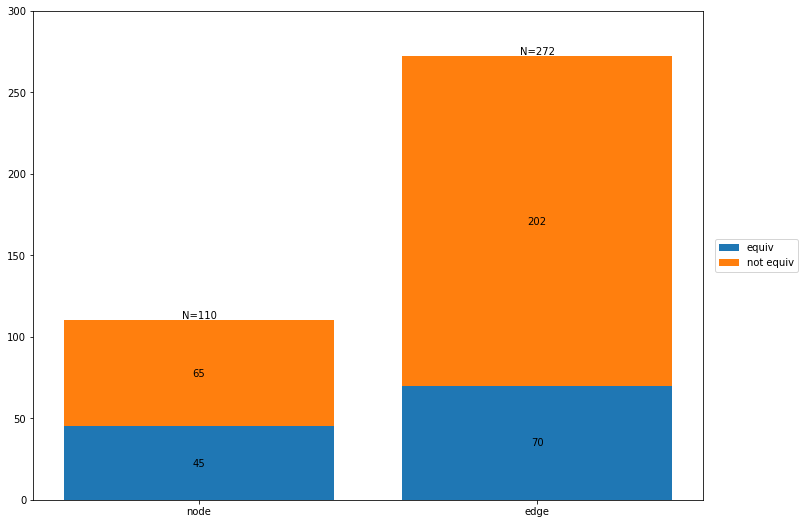

In [81]:
x = ["node","edge"]
y1 = np.array([res_TLGL[0],res_TLGL[1]])
y2 = np.array([res_TLGL[2],res_TLGL[3]])

# memo of sample number
snum = y1+y2

# normalization
#y1 = y1/snum*100.
#y2 = y2/snum*100.

plt.figure(figsize=(12,9))

# stack bars
plt.bar(x, y1, label='equiv')
plt.bar(x, y2 ,bottom=y1,label='not equiv')

# add text annotation corresponding to the percentage of each data.
for xpos, ypos, yval in zip(x, y1/2, y1):
    plt.text(xpos, ypos, "%d"%yval, ha="center", va="center")
for xpos, ypos, yval in zip(x, y1+y2/2, y2):
    plt.text(xpos, ypos, "%d"%yval, ha="center", va="center")
# add text annotation corresponding to the "total" value of each bar
for xpos, ypos, yval in zip(x, y1+y2, snum):
    plt.text(xpos, ypos, "N=%d"%yval, ha="center", va="bottom")

plt.ylim(0,300)

plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left')
plt.savefig('normalized_stacked_barplot_with_number.png', bbox_inches='tight', pad_inches=0.02)

In [100]:
## Loading the model with Ginsim
lrg3 = ginsim.load("http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml")
## Converting the model to biolqm + Booleanization
lqm3= biolqm.load("http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml")
bn3 = biolqm.to_minibn(biolqm.booleanize(lqm3)).simplify()

## Booleanized model 
mod3 = bn3.to_biolqm()

## Influence graph 
ig3 = biolqm.influence_graph(mod3)

## Conceptual nodes/readouts 
conceptual3 ={'CellCycleArrest','DNAdamage','Apoptosis','Proliferation','ECMicroenv', 'Invasion',
 'Metastasis',
 'Migration'}

##Generation of unitary nodes perturbations
nodes3=set([str(c) for c in mod3.getComponents()])
internal_nodes3=nodes3-conceptual3
nodes_p3={str(c)+'%0' for c in internal_nodes3}.union({str(c)+'%1' for c in internal_nodes3})

##Generation of unitary edges perturbations
internal_edges3=[(source,target) for (source,target) in ig3.edges() if target in internal_nodes3 and source in internal_nodes3]
edges_p3={str(source) +':'+str(target)+'%0' for (source,target) in internal_edges3}.union({str(source) +':'+str(target)+'%1' for (source,target) in internal_edges3})
partition_dict3=unit_perturbation_partitioning(nodes_p3,edges_p3,mod3)

Downloading http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml

Downloading http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml

In [101]:
res_CRC=partition_pert_count(partition_dict3)
res_CRC
("http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml")
{'CellCycleArrest','DNAdamage','Apoptosis','Proliferation','ECMicroenv', 'Invasion',
 'Metastasis',
 'Migration'}

[26, 84, 24, 168]

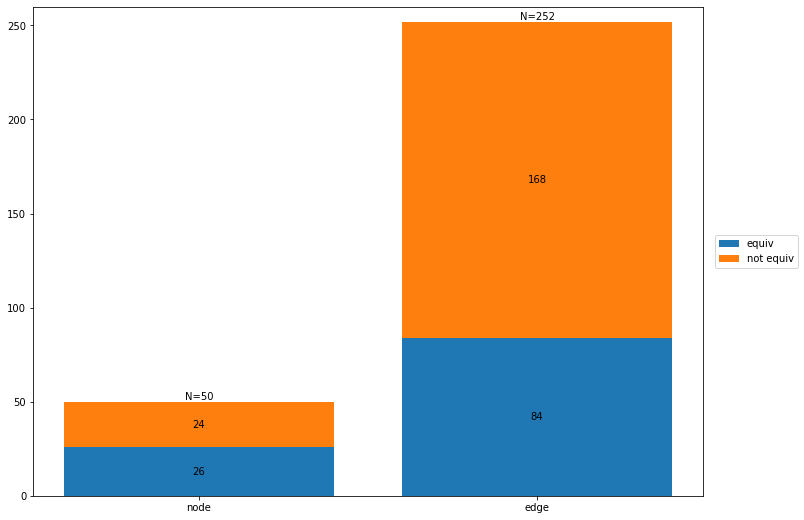

In [103]:
x = ["node","edge"]
y1 = np.array([res_CRC[0],res_CRC[1]])
y2 = np.array([res_CRC[2],res_CRC[3]])

# memo of sample number
snum = y1+y2

# normalization
#y1 = y1/snum*100.
#y2 = y2/snum*100.

plt.figure(figsize=(12,9))

# stack bars
plt.bar(x, y1, label='equiv')
plt.bar(x, y2 ,bottom=y1,label='not equiv')

# add text annotation corresponding to the percentage of each data.
for xpos, ypos, yval in zip(x, y1/2, y1):
    plt.text(xpos, ypos, "%d"%yval, ha="center", va="center")
for xpos, ypos, yval in zip(x, y1+y2/2, y2):
    plt.text(xpos, ypos, "%d"%yval, ha="center", va="center")
# add text annotation corresponding to the "total" value of each bar
for xpos, ypos, yval in zip(x, y1+y2, snum):
    plt.text(xpos, ypos, "N=%d"%yval, ha="center", va="bottom")

plt.ylim(0,260)

plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left')
plt.savefig('normalized_stacked_barplot_with_number.png', bbox_inches='tight', pad_inches=0.02)

Downloading http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml

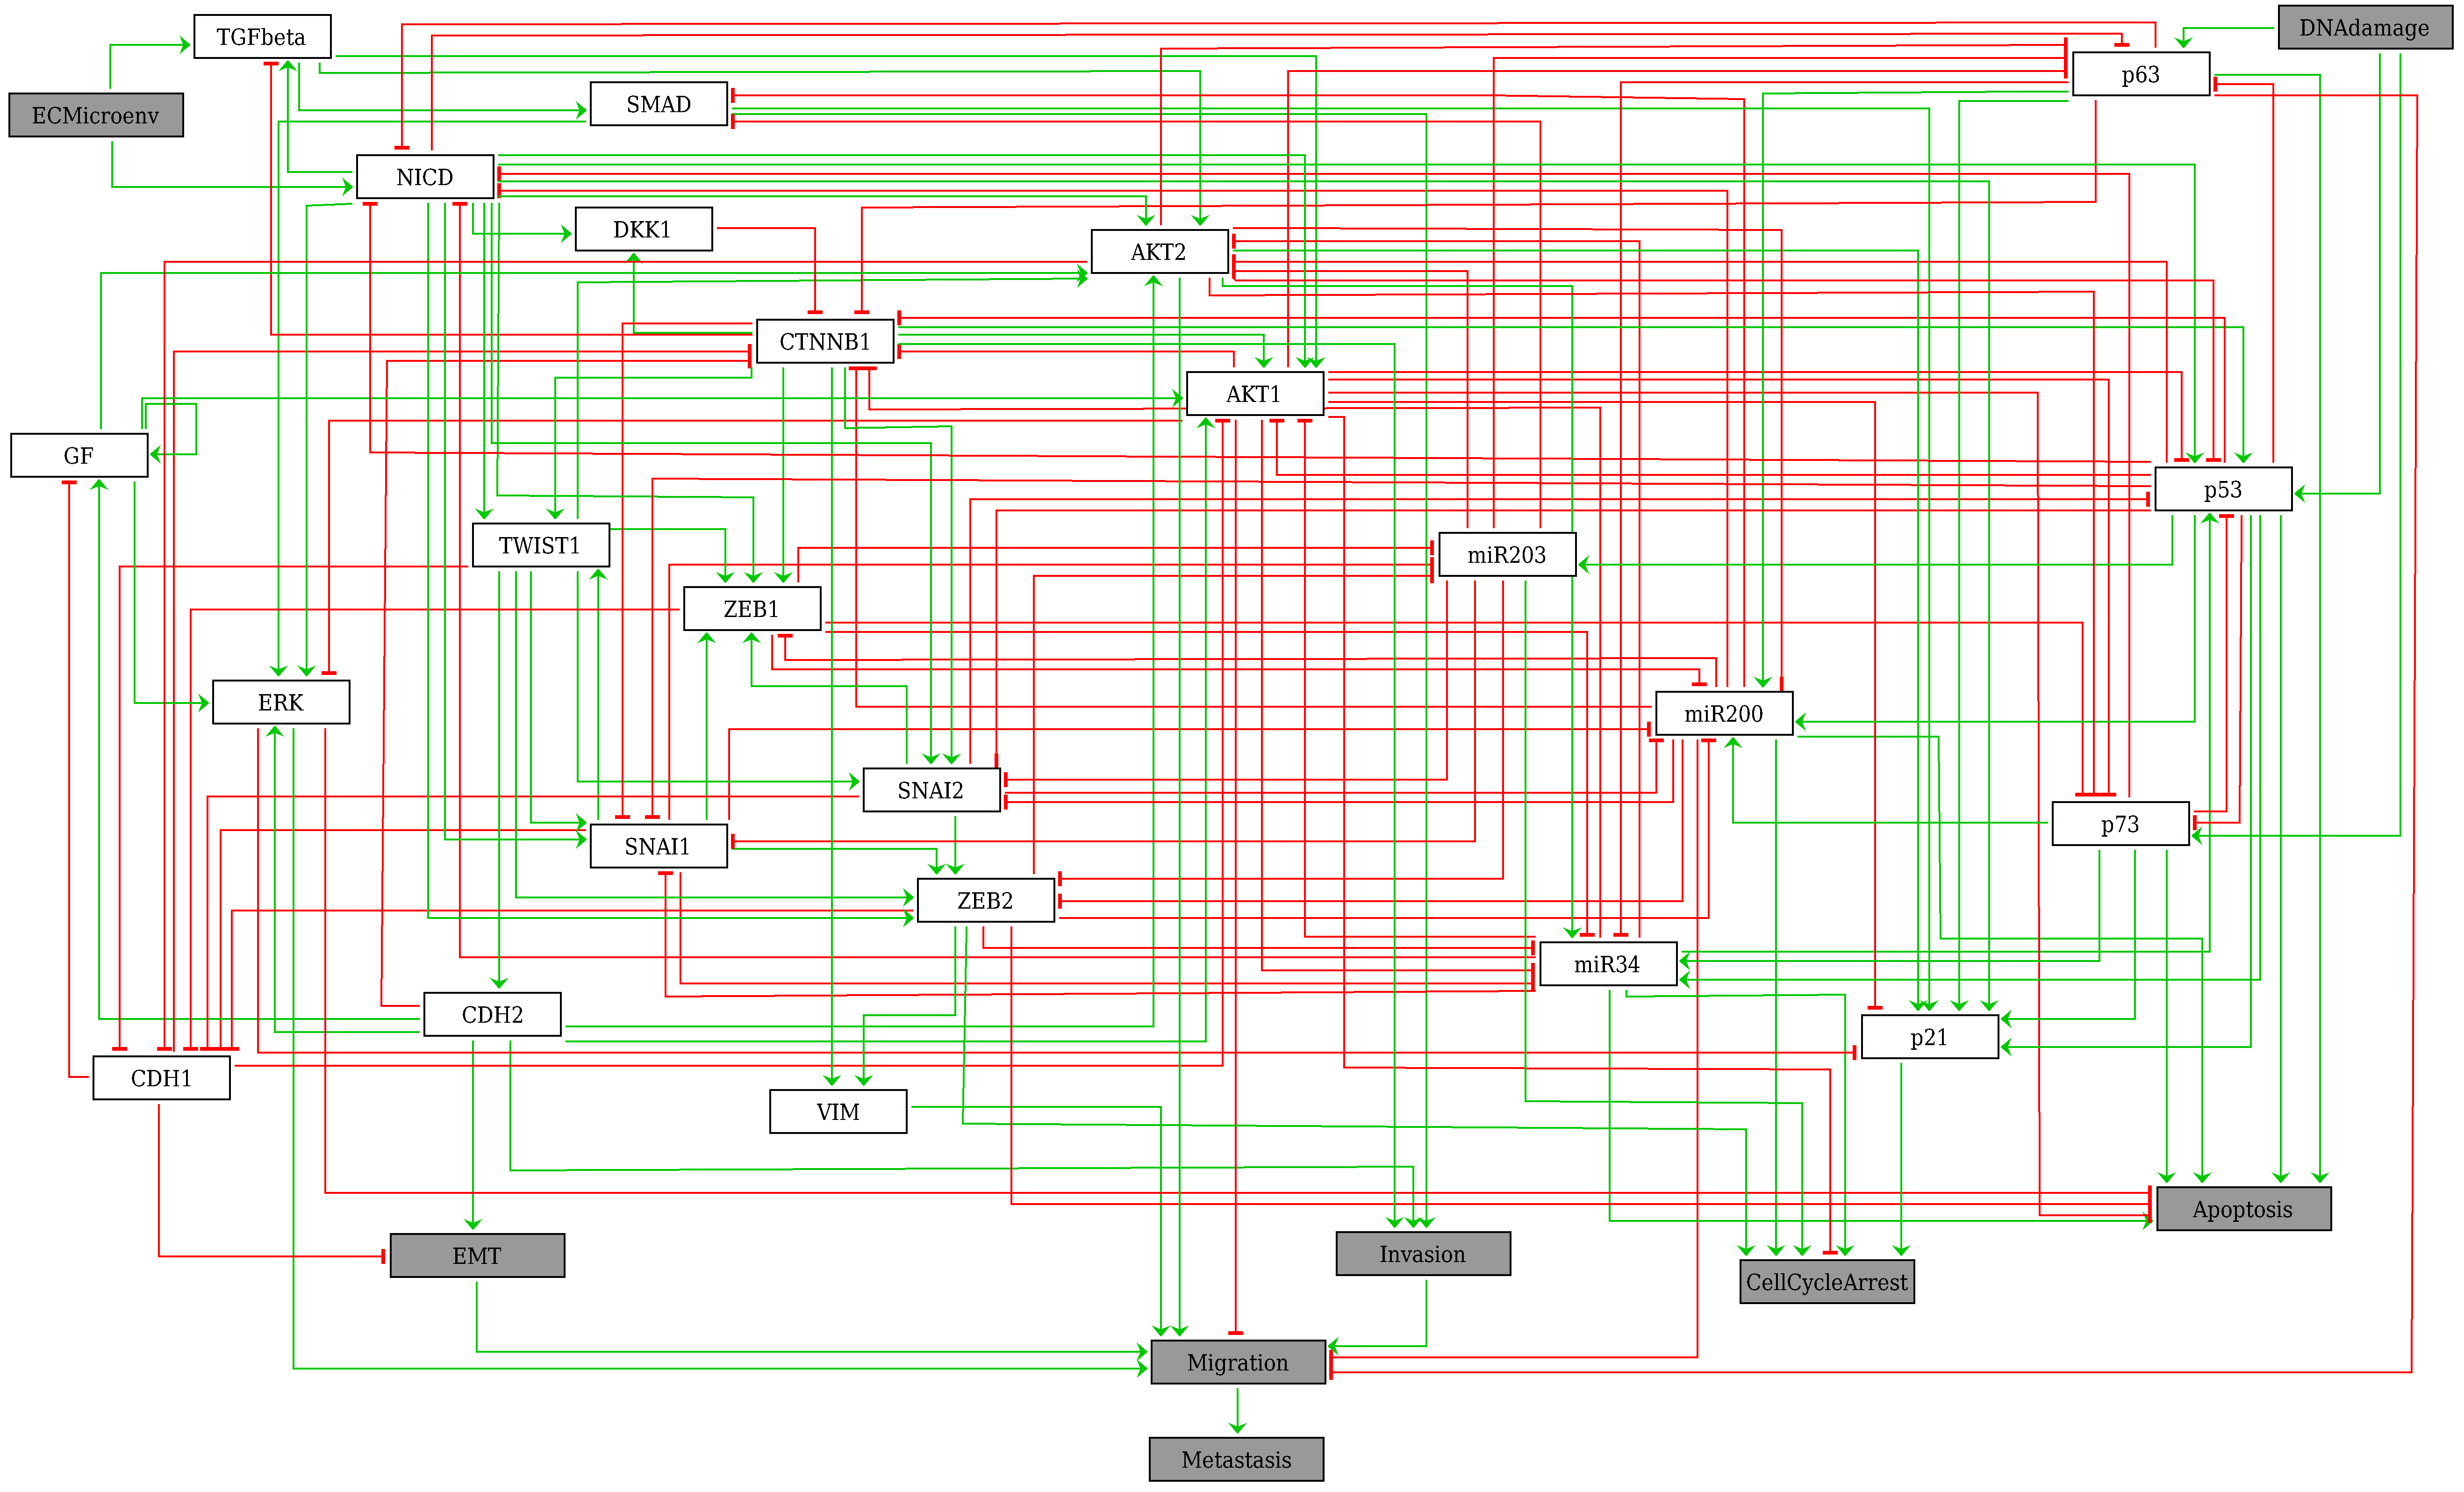

In [9]:
lrg3 = ginsim.load("http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml")
ginsim.show(lrg3)